# KZ NOTE:

    3. add an activation (softplus) layer in the end of output layer ---- prevent giving negative values

    2. same as v_2 that early stopping after 50

    1. in this version the early stopping tracker only start after 150 epoch.
        but I feel it starts to overfit. In _v2 I'll turn that off and start early stopping after 50 epoch

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [6]:
from compression_nn.preprocess import MinMaxNormalizer

In [7]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(pars_train)


Train with all 16 parameters.
max-min normalize the labels


In [11]:
num_samples = len(pars_train)
# split the sample for training ----------
train_split, val_split = int(0.9*num_samples), int(0.1*num_samples)


In [12]:
# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split],
    train_y=pars_train[:train_split],
    val_x=dv[train_split:],
    val_y=pars_train[train_split:],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

In [13]:
train_loader

# Start Training!

In [14]:
hyperparameter_configs = [
    {
        'test_id': 'all_param_v1',
        'hidden_dims': [64, 64],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus()
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [02:16<01:48,  1.23it/s]

Epoch 166/300:
Training Loss: 0.098354
Validation Loss: 0.100408


 60%|██████    | 181/300 [02:28<01:33,  1.27it/s]

Epoch 181/300:
Training Loss: 0.098203
Validation Loss: 0.098295


 65%|██████▌   | 196/300 [02:40<01:24,  1.22it/s]

Epoch 196/300:
Training Loss: 0.098242
Validation Loss: 0.125013


 69%|██████▉   | 207/300 [02:50<01:16,  1.22it/s]

Early stopping triggered after 208 epochs
Best validation loss is 0.09804864934292333
Model and preprocessing saved to models/model_all_param_v1.pkl


In [15]:
hyperparameter_configs = [
    {
        'test_id': 'all_param_v2',
        'hidden_dims': [128, 64, 32],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus()
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [02:48<02:14,  1.01s/it]

Epoch 166/300:
Training Loss: 0.100497
Validation Loss: 0.100825


 60%|██████    | 181/300 [03:03<01:59,  1.01s/it]

Epoch 181/300:
Training Loss: 0.100187
Validation Loss: 0.098916


 65%|██████▌   | 196/300 [03:18<01:44,  1.00s/it]

Epoch 196/300:
Training Loss: 0.100464
Validation Loss: 0.099039


 69%|██████▉   | 207/300 [03:30<01:34,  1.02s/it]

Early stopping triggered after 208 epochs
Best validation loss is 0.09876490692640173
Model and preprocessing saved to models/model_all_param_v2.pkl


In [16]:
hyperparameter_configs = [
    {
        'test_id': 'all_param_v3',
        'hidden_dims': [128, 128, 128],
        'dropout_rate': 0.2
    },

]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus()
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [02:45<02:13,  1.00it/s]

Epoch 166/300:
Training Loss: 0.097020
Validation Loss: 0.100858


 60%|██████    | 181/300 [03:00<01:59,  1.00s/it]

Epoch 181/300:
Training Loss: 0.097240
Validation Loss: 0.099283


 65%|██████▌   | 196/300 [03:15<01:42,  1.01it/s]

Epoch 196/300:
Training Loss: 0.097095
Validation Loss: 0.122032


 65%|██████▌   | 196/300 [03:16<01:44,  1.00s/it]

Early stopping triggered after 197 epochs
Best validation loss is 0.0981113584391002
Model and preprocessing saved to models/model_all_param_v3.pkl


# plot validations

In [18]:
from compression_nn.utils import plot_test_error

In [58]:
def plot_test_error_all_param(model, test_loader, n_params, label_normalizer=None, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=range(n_params)

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    points = 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model.predict(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            if isinstance(y_NN, torch.Tensor):
                y_NN = y_NN.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN

            points    += x.shape[0]
            
    # inverse-normalization if needed
    if label_normalizer is not None:
        params_NN   = label_normalizer.inverse_transform(params_NN)

    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    # KZ: let me first assume n_params is even 
    f, axarr = plt.subplots(n_params//2, 2, figsize=(15,5*n_params//2))
    
    for i in range(n_params):
        
        if i%2==0:
            row_idx = i//2
    
            axarr[row_idx,0].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

            axarr[row_idx,0].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
            axarr[row_idx,0].set_xlabel(r"True param "+str(i))
            axarr[row_idx,0].set_ylabel(r"Predicted param "+ str(i))

            axarr[row_idx,0].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,0].transAxes)
            axarr[row_idx,0].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,0].transAxes)

        else:
            row_idx = i//2
            
            axarr[row_idx,1].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

            axarr[row_idx,1].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
            axarr[row_idx,1].set_xlabel(r"True param "+str(i))
            axarr[row_idx,1].set_ylabel(r"Predicted param "+ str(i))

            axarr[row_idx,1].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            axarr[row_idx,1].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            
    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

 RMSE = 0.036
 $R^2$ = 0.994
Error S_8 = 9.040


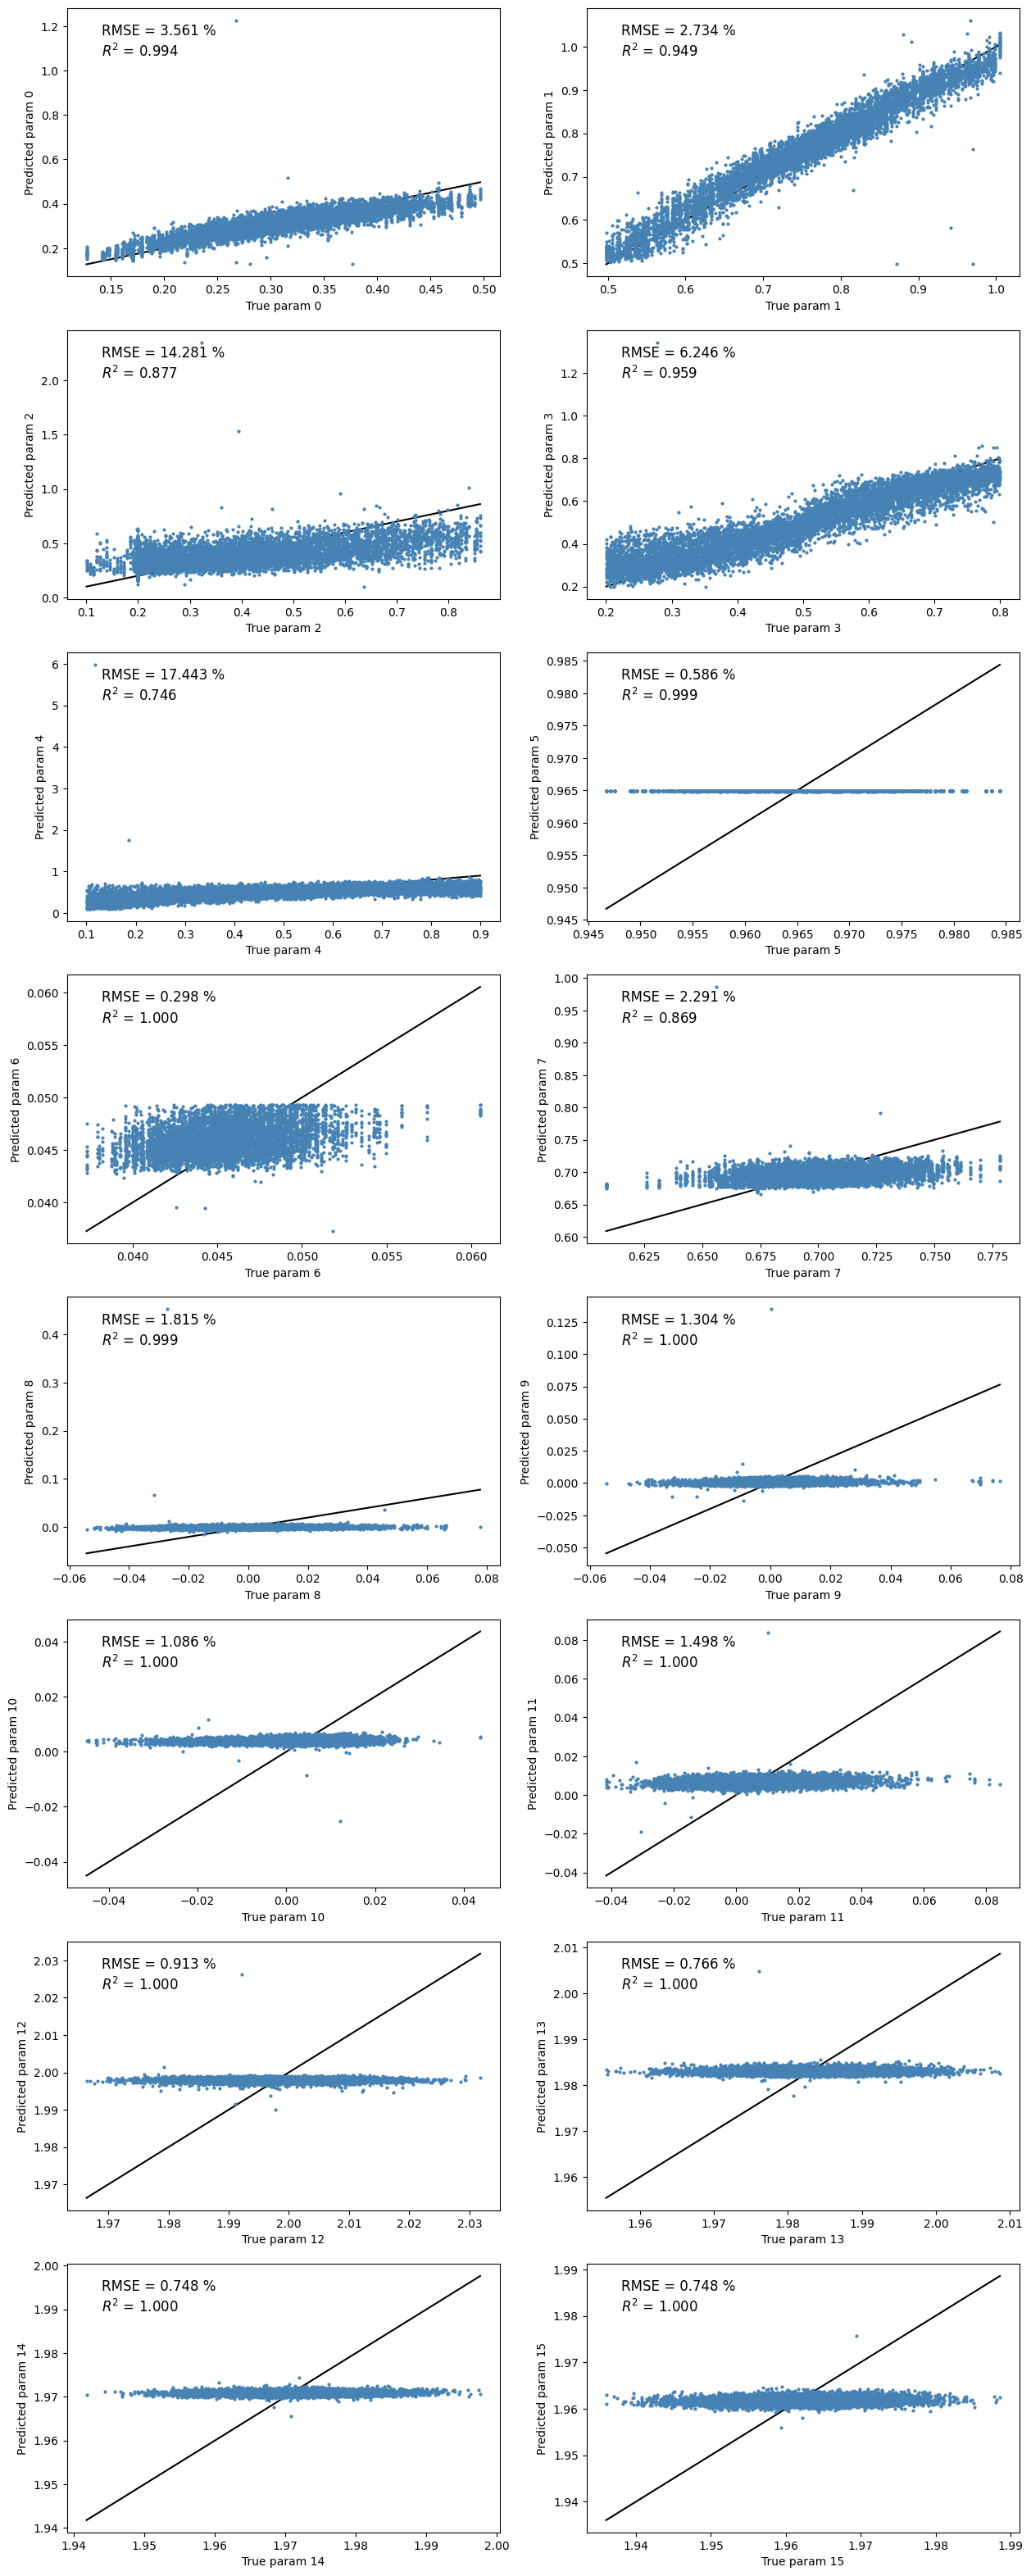

In [59]:
loaded_model = CompressionNN.load('all_param_v1')
loaded_model.model.to('cpu')

plot_test_error_all_param(loaded_model, test_loader, n_params=16, label_normalizer=label_normalizer, device='cpu', output=False)


 RMSE = 0.038
 $R^2$ = 0.993
Error S_8 = 9.027


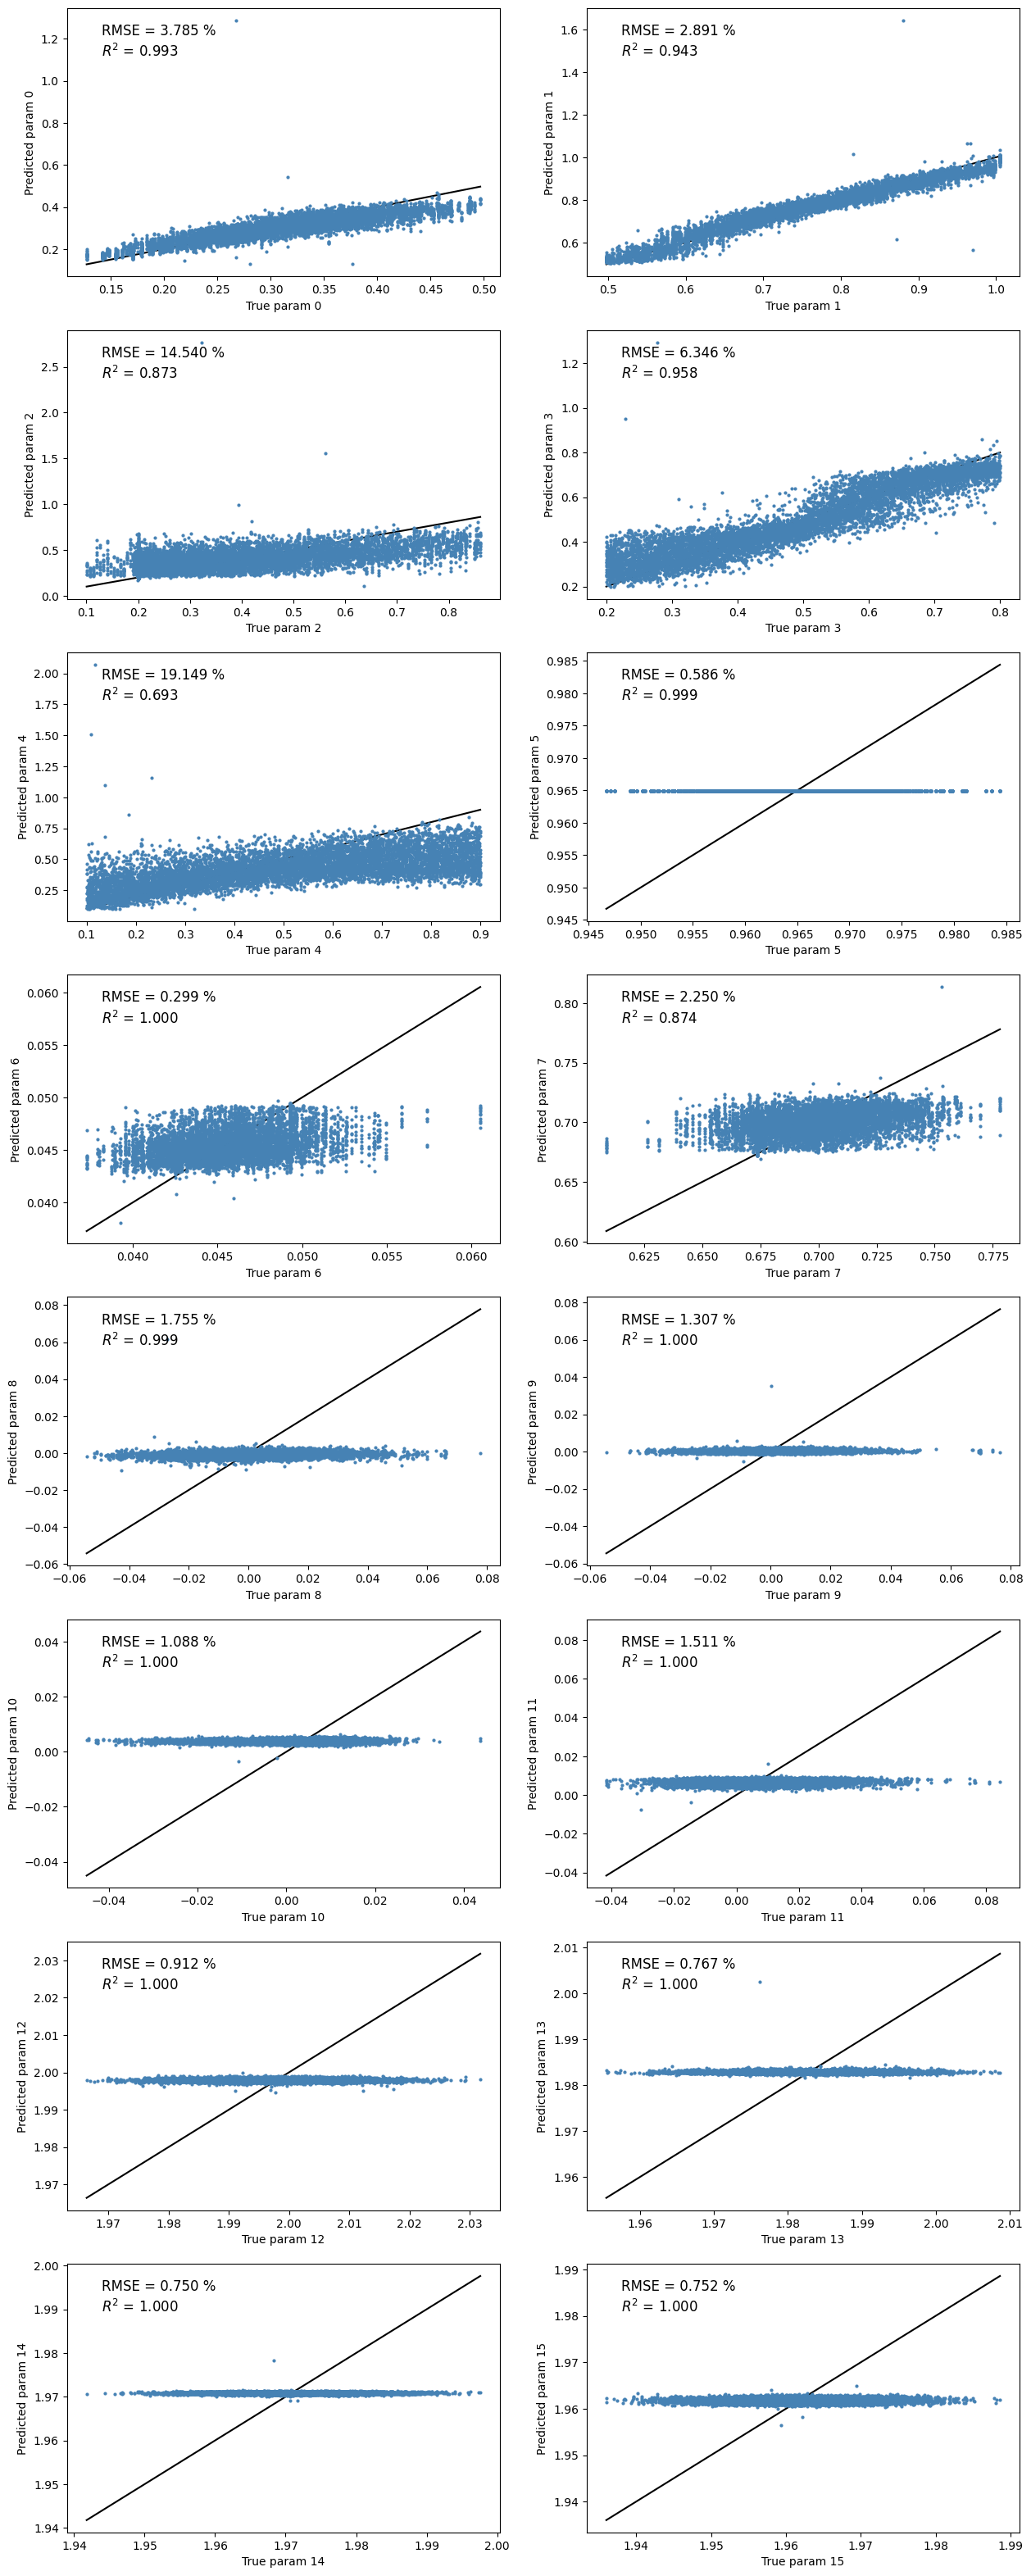

In [60]:
loaded_model = CompressionNN.load('all_param_v2')
loaded_model.model.to('cpu')

plot_test_error_all_param(loaded_model, test_loader, n_params=16, label_normalizer=label_normalizer, device='cpu', output=False)
